In [22]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
import hashlib
import swifter
from scipy import stats

In [23]:
 connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20240120',
    'user':'student',
    'password':'dpo_python_2020'
}

query = '''
select user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2023-12-29' and toDate(time) <= '2024-01-04'
group by exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [24]:
print(df)

       user_id  exp_group  likes  views       ctr
0        18392          1      7     32  0.218750
1       115383          3     12     44  0.272727
2       123580          3      2     11  0.181818
3       131473          2      9    108  0.083333
4       107323          4      5     31  0.161290
...        ...        ...    ...    ...       ...
49809    27030          0     12     64  0.187500
49810   122758          3     20    118  0.169492
49811   132567          1     52    326  0.159509
49812   122190          3     19     65  0.292308
49813    17310          2      9     82  0.109756

[49814 rows x 5 columns]


## Анализирую тест между группами 0 и 3 по метрике линеаризованных лайков.

In [26]:
#отфильтровал строки для групп 0 и 3
filter_df_0_and_3 = df[(df['exp_group'] == 0) | (df['exp_group'] == 3)]
print(filter_df_0_and_3)

       user_id  exp_group  likes  views       ctr
1       115383          3     12     44  0.272727
2       123580          3      2     11  0.181818
7        30319          0     25    114  0.219298
9       118359          3      7     38  0.184211
11        7626          0     14     39  0.358974
...        ...        ...    ...    ...       ...
49795   110492          0      4     17  0.235294
49808   136299          0     35    116  0.301724
49809    27030          0     12     64  0.187500
49810   122758          3     20    118  0.169492
49812   122190          3     19     65  0.292308

[19922 rows x 5 columns]


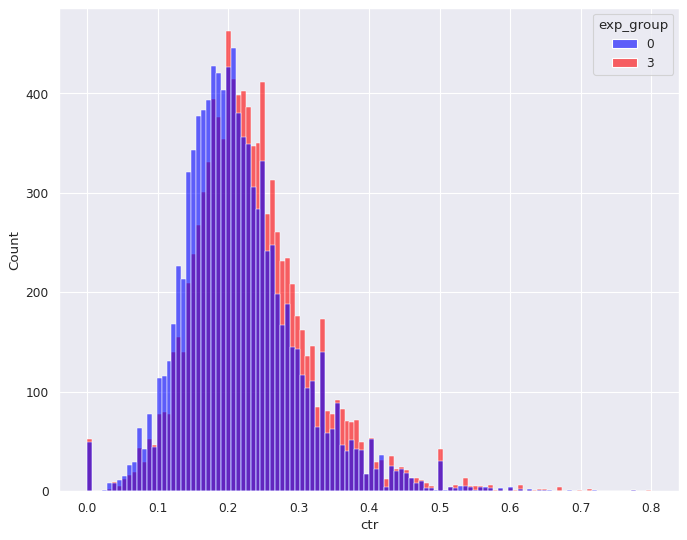

In [32]:
#Визуализирую распределения CTR по группам 0 и 3
sns.set(rc={'figure.figsize':(10, 8), 'figure.dpi': 80})
g = sns.histplot(data = filter_df_0_and_3, x = 'ctr', hue = 'exp_group', palette = ['blue','red'], alpha = 0.6, kde = False)

Распределения выглядят почти равномерными и прокрасились

In [37]:
#отфильтровываю датафрйем для группы 0
filter_df_0 = filter_df_0_and_3[filter_df_0_and_3['exp_group'] == 0]
print(filter_df_0)

       user_id  exp_group  likes  views       ctr
7        30319          0     25    114  0.219298
11        7626          0     14     39  0.358974
25       12217          0     12     52  0.230769
26        3450          0     10     42  0.238095
28      109621          0     25    166  0.150602
...        ...        ...    ...    ...       ...
49790   109908          0      2     17  0.117647
49792   137355          0     24    127  0.188976
49795   110492          0      4     17  0.235294
49808   136299          0     35    116  0.301724
49809    27030          0     12     64  0.187500

[9920 rows x 5 columns]


In [38]:
#отфильтровываю датафрйем для группы 3
filter_df_3 = filter_df_0_and_3[filter_df_0_and_3['exp_group'] == 3]
print(filter_df_3)

       user_id  exp_group  likes  views       ctr
1       115383          3     12     44  0.272727
2       123580          3      2     11  0.181818
9       118359          3      7     38  0.184211
12       16699          3      6     16  0.375000
14      138445          3     18     93  0.193548
...        ...        ...    ...    ...       ...
49778    17042          3      3     12  0.250000
49779   108659          3      0      9  0.000000
49782   123869          3     24     78  0.307692
49810   122758          3     20    118  0.169492
49812   122190          3     19     65  0.292308

[10002 rows x 5 columns]


## Группа 0 - контрольная группа, группа 3 - тестовая

In [50]:
#проведу сначала t-тест по CTR
stats.ttest_ind(filter_df_0_and_3[filter_df_0_and_3.exp_group == 0].ctr,
          filter_df_0_and_3[filter_df_0_and_3.exp_group == 3].ctr,
          equal_var=False)

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

!!!p-value < 0.05, значит есть отличия в группах 0 и 3

In [39]:
#посчитаю CTR для контрольной группы
CTR_0 = filter_df_0['likes'].sum() / filter_df_0['views'].sum()
print(CTR_0)

0.20983799195924746


In [41]:
#считаю метрику linearized_likes
filter_df_0_and_3['linearized_likes'] = filter_df_0_and_3['likes'] - CTR_0 * filter_df_0_and_3['views']
print(filter_df_0_and_3)

       user_id  exp_group  likes  views       ctr  linearized_likes
1       115383          3     12     44  0.272727          2.767128
2       123580          3      2     11  0.181818         -0.308218
7        30319          0     25    114  0.219298          1.078469
9       118359          3      7     38  0.184211         -0.973844
11        7626          0     14     39  0.358974          5.816318
...        ...        ...    ...    ...       ...               ...
49795   110492          0      4     17  0.235294          0.432754
49808   136299          0     35    116  0.301724         10.658793
49809    27030          0     12     64  0.187500         -1.429631
49810   122758          3     20    118  0.169492         -4.760883
49812   122190          3     19     65  0.292308          5.360531

[19922 rows x 6 columns]


/tmp/ipykernel_310/2521860855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df_0_and_3['linearized_likes'] = filter_df_0_and_3['likes'] - CTR_0 * filter_df_0_and_3['views']


In [45]:
#t-test по метрике linearized_likes
stats.ttest_ind(filter_df_0_and_3[filter_df_0_and_3.exp_group == 0].linearized_likes,
               filter_df_0_and_3[filter_df_0_and_3.exp_group == 3].linearized_likes, equal_var = False)

Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

!!!p-value в t-test < 0.05, что говорит о различиях в группах 0 и 3

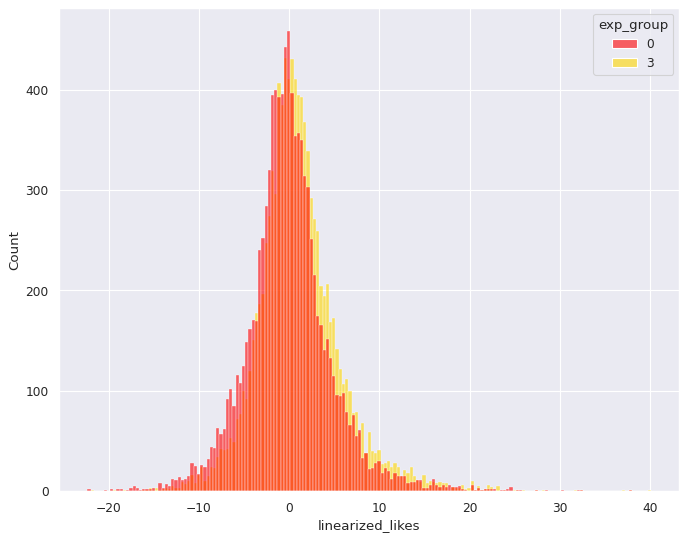

In [48]:
#Визуализирую распределения linearized_likes по группам 0 и 3
sns.set(rc={'figure.figsize':(10, 8), 'figure.dpi': 80})
j = sns.histplot(data = filter_df_0_and_3, x = 'linearized_likes', hue = 'exp_group', palette = ['red','gold'], alpha = 0.6, kde = False)

Графики прокрасились и распределения 'на глаз' стали более равномерными

## Вывод: и по метрике CTR и по метрике linearized_likes с помощью t-test были обнаружены значимые различия в группе, но во втором тесте результат показал более значимый результат, p-value во 2 тесте значительно меньше p-value 1 теста

## Анализирую тест между группами 1 и 2 по метрике линеаризованных лайков.

In [51]:
#отфильтровал строки для групп 1 и 2
filter_df_1_and_2 = df[(df['exp_group'] == 1) | (df['exp_group'] == 2)]
print(filter_df_1_and_2)

       user_id  exp_group  likes  views       ctr
0        18392          1      7     32  0.218750
3       131473          2      9    108  0.083333
5        32420          2     13     44  0.295455
6        24239          2     40     90  0.444444
8        27443          1     22    109  0.201835
...        ...        ...    ...    ...       ...
49802    21697          1      2     22  0.090909
49804     1232          2      5     96  0.052083
49807   120653          1      8     42  0.190476
49811   132567          1     52    326  0.159509
49813    17310          2      9     82  0.109756

[19897 rows x 5 columns]


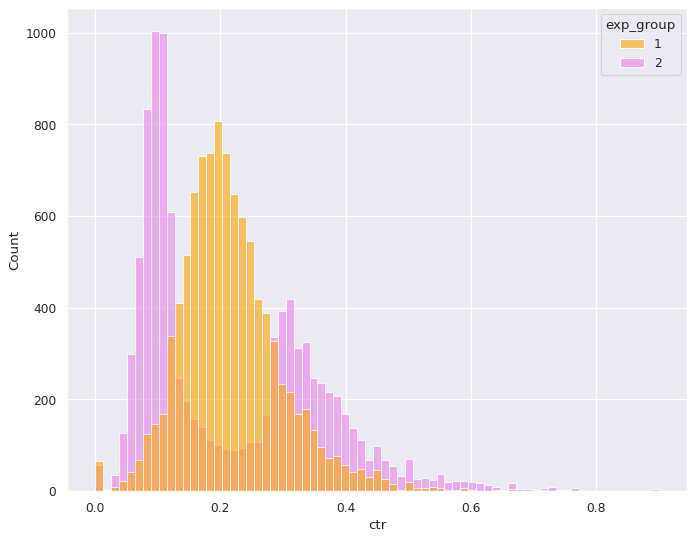

In [52]:
#Визуализирую распределения CTR по группам 0 и 3
sns.set(rc={'figure.figsize':(10, 8), 'figure.dpi': 80})
g = sns.histplot(data = filter_df_1_and_2, x = 'ctr', hue = 'exp_group', palette = ['orange','violet'], alpha = 0.6, kde = False)

!!!Распределение в 1ой группе равномерное, а в группе 2 - "двугорбое", графики прокрасились

In [53]:
#отфильтровываю датафрйем для группы 0
filter_df_1 = filter_df_1_and_2[filter_df_1_and_2['exp_group'] == 1]
print(filter_df_1)

       user_id  exp_group  likes  views       ctr
0        18392          1      7     32  0.218750
8        27443          1     22    109  0.201835
10       27131          1     12     89  0.134831
13      115796          1      6     57  0.105263
15      123999          1     22     92  0.239130
...        ...        ...    ...    ...       ...
49796    30210          1     11     51  0.215686
49800    22025          1     31    160  0.193750
49802    21697          1      2     22  0.090909
49807   120653          1      8     42  0.190476
49811   132567          1     52    326  0.159509

[10020 rows x 5 columns]


In [54]:
#отфильтровываю датафрйем для группы 2
filter_df_2 = filter_df_1_and_2[filter_df_1_and_2['exp_group'] == 2]
print(filter_df_2)

       user_id  exp_group  likes  views       ctr
3       131473          2      9    108  0.083333
5        32420          2     13     44  0.295455
6        24239          2     40     90  0.444444
16      118619          2      8     65  0.123077
19       10098          2      3      9  0.333333
...        ...        ...    ...    ...       ...
49794     2808          2      1      7  0.142857
49797   135232          2      8     72  0.111111
49801    19894          2      1      6  0.166667
49804     1232          2      5     96  0.052083
49813    17310          2      9     82  0.109756

[9877 rows x 5 columns]


## Группа 1 - контрольная группа, группа 2 - тестовая

In [55]:
#проведу сначала t-тест по CTR
stats.ttest_ind(filter_df_1_and_2[filter_df_1_and_2.exp_group == 1].ctr,
          filter_df_1_and_2[filter_df_1_and_2.exp_group == 2].ctr,
          equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

t-test показал p-value > 0.05, но это может быть неверным результатом, так как распределение для группы 2 не похоже на равномерное, нужно провести еще тест

In [56]:
#посчитаю CTR для контрольной группы
CTR_1 = filter_df_1['likes'].sum() / filter_df_1['views'].sum()
print(CTR_1)

0.2096041628394293


In [57]:
#считаю метрику linearized_likes
filter_df_1_and_2['linearized_likes'] = filter_df_1_and_2['likes'] - CTR_1 * filter_df_1_and_2['views']
print(filter_df_1_and_2)

       user_id  exp_group  likes  views       ctr  linearized_likes
0        18392          1      7     32  0.218750          0.292667
3       131473          2      9    108  0.083333        -13.637250
5        32420          2     13     44  0.295455          3.777417
6        24239          2     40     90  0.444444         21.135625
8        27443          1     22    109  0.201835         -0.846854
...        ...        ...    ...    ...       ...               ...
49802    21697          1      2     22  0.090909         -2.611292
49804     1232          2      5     96  0.052083        -15.122000
49807   120653          1      8     42  0.190476         -0.803375
49811   132567          1     52    326  0.159509        -16.330957
49813    17310          2      9     82  0.109756         -8.187541

[19897 rows x 6 columns]


/tmp/ipykernel_310/1852183540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df_1_and_2['linearized_likes'] = filter_df_1_and_2['likes'] - CTR_1 * filter_df_1_and_2['views']


In [58]:
#t-test по метрике linearized_likes
stats.ttest_ind(filter_df_1_and_2[filter_df_1_and_2.exp_group == 1].linearized_likes,
               filter_df_1_and_2[filter_df_1_and_2.exp_group == 2].linearized_likes, equal_var = False)

Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

!!!Значение p-value < 0.05, что говорит о различиях в группах 1 и 2

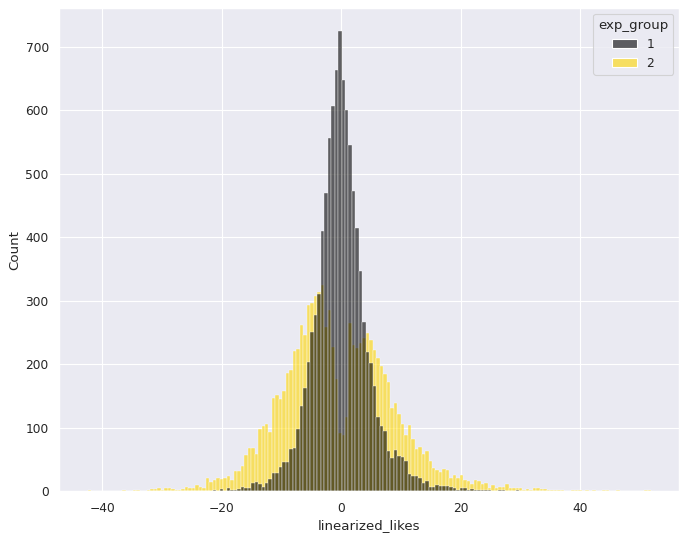

In [61]:
#Визуализирую распределения linearized_likes по группам 1 и 2
sns.set(rc={'figure.figsize':(10, 8), 'figure.dpi': 80})
j = sns.histplot(data = filter_df_1_and_2, x = 'linearized_likes', hue = 'exp_group', palette = ['black','gold'], alpha = 0.6, kde = False)

!!!Графики прокрасились, распределение 2 группы также  остается "двугорбым", но в целом графики стали более равномерными

## Вывод: t-test по метрике CTR дал ложный результат, что различий в группах 1 и 2 нет и p-value > 0.05. t-test по метрике linearized_likes показал значимое различие в группах 1 и 2, показава p-value < 0.05.

## Вывод по всей работе: я провел 2 t-test по метрике CTR на группах 0, 3 и на группах 1, 2, а также 2 t-test по метрике linearized_likes на группах 0, 3 и на группах 1, 2. В первом случае по группам 0 и 3 оба т-теста по обеим метрикам показали различия в группах, во втором случае по группам 1 и 2 т-тест по метрике CTR не увидел различий в группах, а т-тест по метрике linearized_likes показал значимые различия в двух группах. Можно сделать вывод, что метод анализа тестов над метриками-отношениями показывает более точные результаты.